# 导入相关包

In [32]:
import numpy as np
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import matplotlib.pyplot as plt
import matplotlib.ticker
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 设置字体
plt.rcParams["axes.unicode_minus"] = False  # 该语句解决图像中的“-”负号的乱码问题
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.__version__)
if device == "cuda": print(torch.cuda.get_device_name()) 

cuda
2.0.0+cu117


# 读取散射声压边界条件数据
- 读入comsl导出的散射表面边界条件文件：sc_pressure.txt

散射点坐标数据尺寸= (100, 2)
散射点声压数据尺寸= (100, 2)


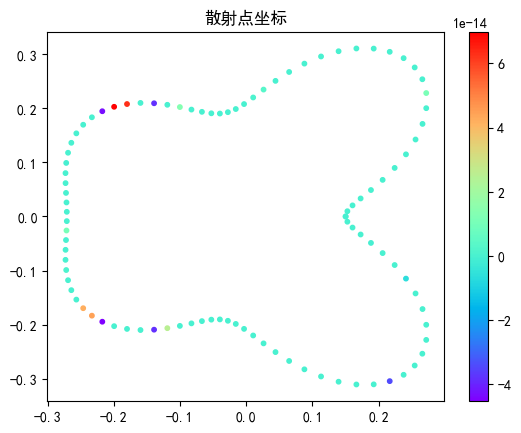

In [33]:
#首先制作散射边界数据
#读取坐标
#只读取最后一个频率数据！！！！！！
file= open('sc_pressure.txt', 'r')
lines = file.readlines()
sc_point = []#散射边界坐标
sc_pressure = []#散射边界声压
linenum = 1
for line in lines:
    x = line.strip().split()
    if linenum>=10:
        #读取散射边界点坐标
        sc_point.append([float(x[0]),float(x[1])])
        #读取最后一个频率的实部和虚部
        sc_pressure.append([float(x[-2]),float(x[-1])]) 
        #sc_pressure.append([complex(x[-2]),complex(x[-1])]) 
    linenum+=1
sc_point = np.array(sc_point)
sc_pressure = np.array(sc_pressure)

# 关闭文件
file.close()
print("散射点坐标数据尺寸=",sc_point.shape)
print("散射点声压数据尺寸=",sc_pressure.shape)
scatter = plt.scatter(sc_point[:,0],sc_point[:,1],s=10,c =sc_pressure[:,0] ,cmap='rainbow')
plt.colorbar(scatter)
#scatter=plt.scatter(sc_point[:,0],sc_point[:,1])
plt.title("散射点坐标")
plt.show()

# 读取正方形测量边界数据
- 读入comsl导出的测量边界文件：rec_pressure.txt

测量点点坐标数据尺寸= (200, 2)
测量点声压数据尺寸= (200, 2)


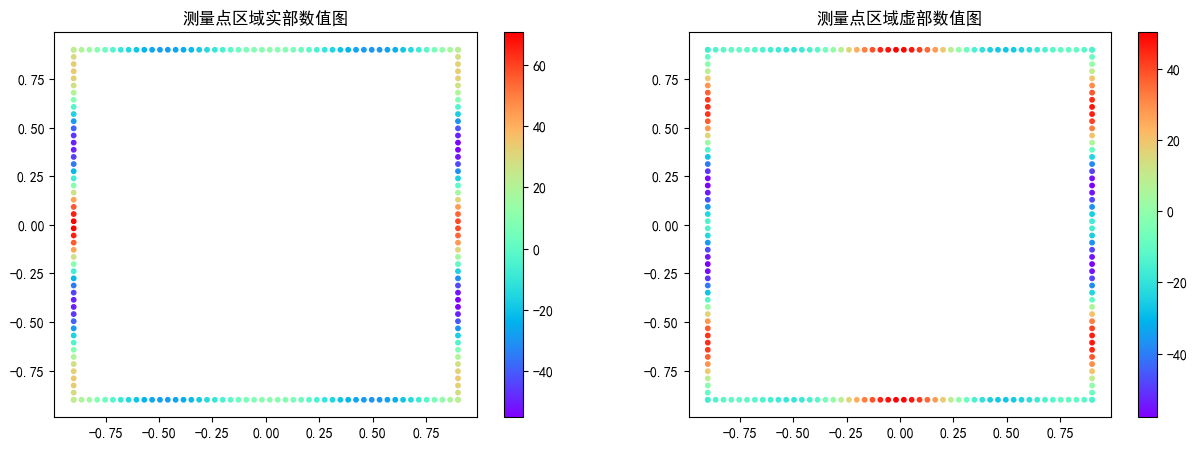

In [34]:
# 读取正方形测量边界数据
#读取坐标和最后一个频点数据
file= open('rec_pressure.txt', 'r')
lines = file.readlines()
rec_point = []
rec_pressure = []
linenum = 1
for line in lines:
    x = line.strip().split()
    if linenum>=10:
        rec_point.append([float(x[0]),float(x[1])])
        #读取最后一个频率的实部和虚部
        rec_pressure.append([float(x[-2]),float(x[-1])]) 
        #sc_pressure.append([complex(x[-2]),complex(x[-1])]) 
    linenum+=1
rec_point = np.array(rec_point)
rec_pressure = np.array(rec_pressure)
file.close()
print("测量点点坐标数据尺寸=",rec_point.shape)
print("测量点声压数据尺寸=",rec_pressure.shape)

plt.figure(figsize=(15, 5))
plt.subplot(121)
scatter = plt.scatter(rec_point[:,0],rec_point[:,1],s=10,c =rec_pressure[:,0] ,cmap='rainbow')
plt.colorbar(scatter)
plt.title("测量点区域实部数值图")
plt.subplot(122)
scatter = plt.scatter(rec_point[:,0],rec_point[:,1],s=10,c =rec_pressure[:,1] ,cmap='rainbow' )
plt.colorbar(scatter)
plt.title("测量点区域虚部数值图")
plt.show()


# 读取Comsol仿真结果数据
- 读入comsl导出的网格数据文件：shape_1_result.txt
- 只取最后一个频率的结果，一列实部，一列虚部
- 在网格中筛选出 $-0.9<x,y<0.9$ 的节点

(9127, 4)
PDE点坐标数据尺寸= (3682, 2)
PDE点声压数据尺寸= (3682, 2)


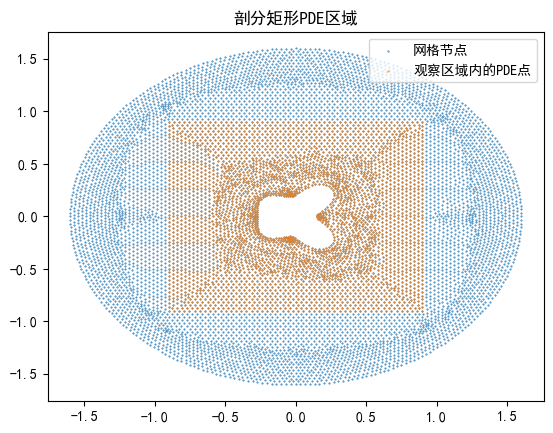

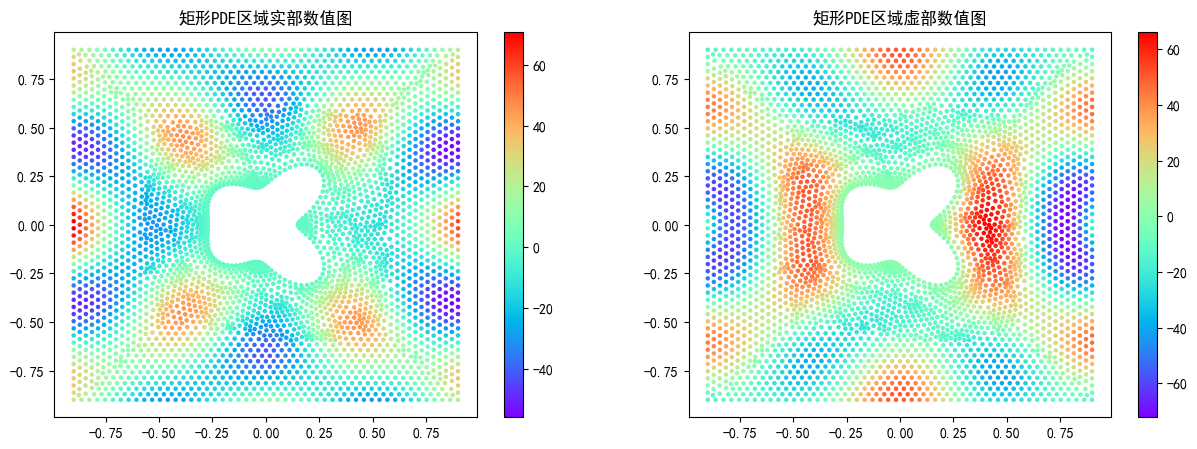

In [35]:
# 步骤1：打开txt文件
file_mesh = open('shape_1_result.txt', 'r')

# 步骤2：逐行读取文件内容
lines = file_mesh.readlines()

# 步骤3：解析每行的坐标数据
coordinates_mesh = []
linenum = 1
for line in lines:
    x = line.strip().split()
    if linenum>=10:
        #x坐标，y坐标，实部，虚部
        coordinates_mesh.append([float(x[0]),float(x[1]),float(x[-2]),float(x[-1])])
    linenum+=1
# 步骤4：存储坐标数据
# 可以在这里执行任何后续操作，例如计算坐标的平均值或绘制图形等
coordinates_mesh = np.array(coordinates_mesh)
# 步骤5：关闭文件
file_mesh.close()
print(coordinates_mesh.shape)

plt.figure()
plt.scatter(coordinates_mesh[:,0],coordinates_mesh[:,1],s=0.2,label = '网格节点')

x1=-0.9;x2=0.9;y1=-0.9;y2=0.9
pde_point = []
pde_pressure = []
for i in coordinates_mesh:
    if x1<=i[0] and i[0]<=x2 and i[1]>=y1 and i[1]<=y2:
        #if i[0]<-0.5 or i[0]>0.5 or i[1]<-0.5 or i[1]>0.5:
        pde_point.append([i[0],i[1]])
        pde_pressure.append([i[2],i[3]])
pde_point = np.array(pde_point)
pde_pressure = np.array(pde_pressure)
print("PDE点坐标数据尺寸=",pde_point.shape)
print("PDE点声压数据尺寸=",pde_pressure.shape)
plt.scatter(pde_point[:,0],pde_point[:,1],s=0.2,label = '观察区域内的PDE点')
plt.legend()
plt.title("剖分矩形PDE区域")
plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(121)
scatter = plt.scatter(pde_point[:,0],pde_point[:,1],s=5,c =pde_pressure[:,0],cmap='rainbow' )
plt.colorbar(scatter)
plt.title("矩形PDE区域实部数值图")
plt.subplot(122)
scatter = plt.scatter(pde_point[:,0],pde_point[:,1],s=5,c =pde_pressure[:,1] ,cmap='rainbow')
plt.colorbar(scatter)
plt.title("矩形PDE区域虚部数值图")
plt.show()

# 前处理数据
- X_f_train：正方形区域内的所有PDE点坐标
- u_f_train：正方形区域内所有PDE点的声压，进行除以100.0的缩放处理
- X_u_train：已知声压的坐标点
- u_train  ：已知声压，进行除以100.0的缩放处理
- X_u_test_tensor ：囊括正方形区域的全局坐标
- u ：全局声压，进行除以100.0的缩放处理
- k : 二维声散射问题的波数

训练PDE点数据集尺寸= torch.Size([3682, 2])
训练边界数据尺寸= torch.Size([300, 2])
测试PDE数据尺寸= torch.Size([9127, 2])


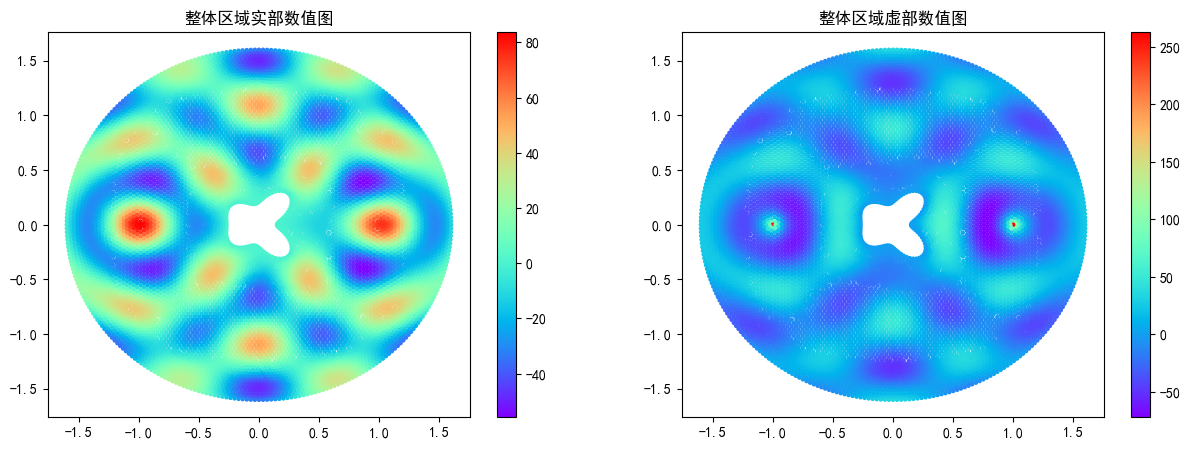

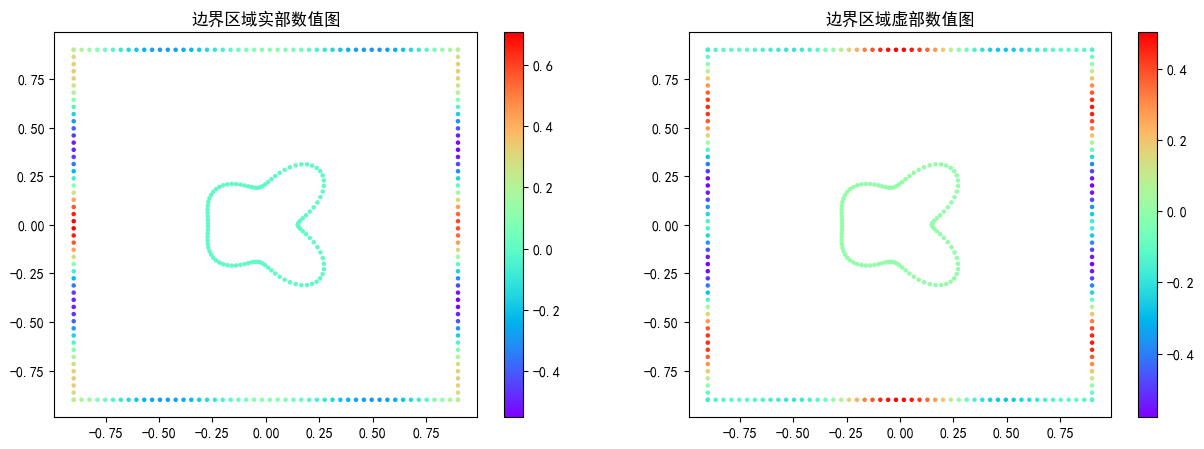

In [36]:
'Convert to tensor and send to GPU'
#X_f_train为pde点
X_f_train = torch.from_numpy(pde_point).float().to(device)
u_f_train = torch.from_numpy(pde_pressure).float().to(device)/100.0
print("训练PDE点数据集尺寸=",X_f_train.shape)
#X_u_train为测量点和散射边界点
# N_u=200
# idx = np.random.choice(pde_point.shape[0], N_u, replace=False)  #筛选随机已知场点
# X_u_train = pde_point[idx[0:N_u], :] #choose indices from  set 'idx' (x,t)
# u_train = pde_pressure[idx[0:N_u],:]      #choose corresponding u
# X_u_train = np.vstack([rec_point,X_u_train])
# X_u_train = torch.from_numpy(X_u_train).float().to(device)
# u_train = np.vstack([rec_pressure,u_train])
# u_train = torch.from_numpy(u_train).float().to(device)/100.0

# X_u_train为测量点和散射边界点的声压条件
X_u_train = np.vstack([sc_point, rec_point])
X_u_train = torch.from_numpy(X_u_train).float().to(device)
u_train = np.vstack([sc_pressure, rec_pressure])
u_train = torch.from_numpy(u_train).float().to(device)/100.0
print("训练边界数据尺寸=",X_u_train.shape)

#X_u_train为测量点和散射边界点
# N_u=50
# idx = np.random.choice(pde_point.shape[0], N_u, replace=False)  #筛选随机已知场点
# X_u_train = pde_point[idx[0:N_u], :] #choose indices from  set 'idx' (x,t)
# u_train = pde_pressure[idx[0:N_u],:]      #choose corresponding u
# X_u_train = np.vstack([rec_point,sc_point,X_u_train])
# X_u_train = torch.from_numpy(X_u_train).float().to(device)
# u_train = np.vstack([rec_pressure,sc_pressure,u_train])
# u_train = torch.from_numpy(u_train).float().to(device)/100.0

# X_u_test_tensor为全局PDE点，包括训练集以外的点
X_u_test_tensor = torch.from_numpy(coordinates_mesh[:,0:2]).float().to(device)
u = torch.from_numpy(coordinates_mesh[:,2:4]).float().to(device)/100.0
print("测试PDE数据尺寸=",X_u_test_tensor.shape)
f_hat = torch.zeros(X_f_train.shape[0],2).to(device)

#定义波数
k=2* np.pi*500/343.3
#归一化参数，按PML边界的包络半径
lb = np.array([-1.6, -1.6]) #lower bound
ub = np.array([1.6, 1.6])  #upper bound

plt.figure(figsize=(15, 5))
plt.subplot(121)
scatter = plt.scatter(coordinates_mesh[:,0],coordinates_mesh[:,1],s=5,c =coordinates_mesh[:,2],cmap='rainbow' )
plt.colorbar(scatter)
plt.title(f"整体区域实部数值图")
plt.subplot(122)
scatter = plt.scatter(coordinates_mesh[:,0],coordinates_mesh[:,1],s=5,c =coordinates_mesh[:,3],cmap='rainbow')
plt.colorbar(scatter)
plt.title(f"整体区域虚部数值图")
plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(121)
scatter = plt.scatter(X_u_train[:,0].cpu().numpy(),X_u_train[:,1].cpu().numpy(),s=5,c =u_train[:,0].cpu().numpy(),cmap='rainbow' )
plt.colorbar(scatter)
plt.title(f"边界区域实部数值图")
plt.subplot(122)
scatter = plt.scatter(X_u_train[:,0].cpu().numpy(),X_u_train[:,1].cpu().numpy(),s=5,c =u_train[:,1].cpu().numpy(),cmap='rainbow' )
plt.colorbar(scatter)
plt.title(f"边界区域虚部数值图")
plt.show()

# Training Data

In [37]:
def trainingdata(N_u,N_f):
    #N_u：边界采样点数
    #N_f：PDE域采样点数（可能采到边界）
    leftedge_x = np.hstack((X[:,0][:,None], Y[:,0][:,None])) #左边界x=-1，[:,None]用于将(n,)向量拓展为矩阵形式的向量(n,1)
    leftedge_u = usol[:,0][:,None]
    
    rightedge_x = np.hstack((X[:,-1][:,None], Y[:,-1][:,None])) #右边界x=1
    rightedge_u = usol[:,-1][:,None]
    
    topedge_x = np.hstack((X[0,:][:,None], Y[0,:][:,None])) #上边界y=1
    topedge_u = usol[0,:][:,None]
    
    bottomedge_x = np.hstack((X[-1,:][:,None], Y[-1,:][:,None]))#下边界y=-1
    bottomedge_u = usol[-1,:][:,None]
    
    all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x])
    all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])  
     
    #choose random N_u points for training
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 
    
    X_u_train = all_X_u_train[idx[0:N_u], :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx[0:N_u],:]      #choose corresponding u
    
    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    X_f = lb + (ub-lb)*lhs(2,N_f) 
    X_f_train = np.vstack((X_f, X_u_train)) # append training points to collocation points ：包括边界采样点和PDE域采样点
    
    return X_f_train, X_u_train, u_train # X_u_train, u_train：边界采样点和边界物理值，X_f_train：边界采样点和PDE域采样点，用于训练，无对应物理值


# Physics Informed Neural Network（搭建神经网络）

In [38]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
        self.layers = layers

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(self.layers[i], self.layers[i+1]) for i in range(len(self.layers)-1)])
        
        '''
        Alternatively:
        
        *all layers are callable 
    
        Simple linear Layers
        self.fc1 = nn.Linear(2,50)
        self.fc2 = nn.Linear(50,50)
        self.fc3 = nn.Linear(50,50)
        self.fc4 = nn.Linear(50,1)
        
        '''
    
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(self.layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
        'grad info'
        self.ur_x= torch.tensor([1.]).to(device)  # 初始化一个波数（自己选择）     
        self.ur_xx=torch.tensor([1.]).to(device)  # 初始化一个波数（自己选择）     
        self.ur_y=torch.tensor([1.]).to(device)  # 初始化一个波数（自己选择）       
        self.ur_yy=torch.tensor([1.]).to(device)  # 初始化一个波数（自己选择）     
        self.ui_x=torch.tensor([1.]).to(device)  # 初始化一个波数（自己选择）          
        self.ui_xx=torch.tensor([1.]).to(device)  # 初始化一个波数（自己选择）      
        self.ui_y=torch.tensor([1.]).to(device)  # 初始化一个波数（自己选择）       
        self.ui_yy =torch.tensor([1.]).to(device)  # 初始化一个波数（自己选择）           
    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input ：对输入进行归一化处理
        #x = (x - l_b)/(u_b - l_b) #feature scaling 不进行归一化
        
        #convert to float
        a = x.float().to(device)
                        
        '''     
        Alternatively:
        
        a = self.activation(self.fc1(a))
        a = self.activation(self.fc2(a))
        a = self.activation(self.fc3(a))
        a = self.fc4(a)
        
        '''
        
        for i in range(len(self.layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)#最后一层没有激活函数
        
        return a
    
                 
    def loss_BC(self,x,y):
                
        #loss_u = self.loss_function(self.forward(x), y)
        loss_u = torch.mean(torch.square(self.forward(x)-y)[:,0])+torch.mean(torch.square(self.forward(x)-y)[:,1])
        return loss_u
    
    def loss_PDE(self, x_to_train_f):
        #x坐标
        x_1_f = torch.tensor(x_to_train_f[:,0:1], requires_grad=True).float().to(device) #x 
        #y坐标
        x_2_f =torch.tensor(x_to_train_f[:,1:2], requires_grad=True).float().to(device)  #y
        #预测场量
        u_pred_train = self.forward(torch.cat([x_1_f, x_2_f], dim=1))

        #分成实部虚部分别求导
        ur_pred_train = (u_pred_train[:,0:1])
        ui_pred_train = (u_pred_train[:,1:2])

        ur_x = torch.autograd.grad(
            ur_pred_train, x_1_f, 
            grad_outputs=torch.ones_like(ur_pred_train),
            retain_graph=True,
            create_graph=True
        )[0]
        ur_xx = torch.autograd.grad(
            ur_x, x_1_f, 
            grad_outputs=torch.ones_like(ur_x),
            retain_graph=True,
            create_graph=True
        )[0] 

        ui_x = torch.autograd.grad(
            ui_pred_train, x_1_f, 
            grad_outputs=torch.ones_like(ui_pred_train),
            retain_graph=True,
            create_graph=True
        )[0]
        ui_xx = torch.autograd.grad(
            ui_x, x_1_f, 
            grad_outputs=torch.ones_like(ui_x),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.cat([ur_xx,ui_xx],dim = 1) 
                                                                            
        ur_y = torch.autograd.grad(
            ur_pred_train, x_2_f, 
            grad_outputs=torch.ones_like(ur_pred_train),
            retain_graph=True,
            create_graph=True
        )[0]
        ur_yy = torch.autograd.grad(
            ur_y, x_2_f, 
            grad_outputs=torch.ones_like(ur_y),
            retain_graph=True,
            create_graph=True
        )[0]
        ui_y = torch.autograd.grad(
            ui_pred_train, x_2_f, 
            grad_outputs=torch.ones_like(ui_pred_train),
            retain_graph=True,
            create_graph=True
        )[0]
        ui_yy = torch.autograd.grad(
            ui_y, x_2_f, 
            grad_outputs=torch.ones_like(ui_y),
            retain_graph=True,
            create_graph=True
        )[0]
        u_yy = torch.cat([ur_yy,ui_yy],dim = 1)   
        
        f = u_xx/(k**2)+ u_yy/(k**2) +  u_pred_train
        # PDE损失函数1分实部虚部计算
        
        loss_f = torch.mean(torch.square(f[:,0]))+torch.mean(torch.square(f[:,1]))
        # PDE损失函数2
        #loss_f = self.loss_function(f,f_hat)
        self.ur_x = ur_x    
        self.ur_xx=ur_xx
        self.ur_y=ur_y
        self.ur_yy=ur_yy
        self.ui_x  =  ui_x
        self.ui_xx=ui_xx
        self.ui_y=ui_y
        self.ui_yy =  ui_yy          
        return loss_f
    
    def loss(self,x,y,x_to_train_f):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(x_to_train_f)
        # loss_val = loss_u
        loss_val = loss_f+loss_u
        #loss_val = loss_f
        return loss_val,loss_u,loss_f
     
    'callable for optimizer'                                       
    def closure(self):
        
        self.optimizer.zero_grad()
        
        loss_val,_,_= self.loss(X_u_train, u_train, X_f_train)
        
        #error_vec, _ = PINN.test()
        
        #print(loss,error_vec)
        
        loss_val.backward()

        return loss_val        
    
    def test(self):
                
        u_pred = self.forward(X_u_test_tensor)
        
        error_vec = torch.linalg.norm((u-u_pred),ord='fro')/torch.linalg.norm(u,ord='fro')        # Relative L2 Norm of the error (Vector)
        
        return error_vec,u_pred
    
    def test_BC(self,bc_x,bc_u,i):
        u_pred = self.forward(bc_x)
        error_vec = torch.linalg.norm((bc_u-u_pred),ord='fro')/torch.linalg.norm(bc_u,ord='fro')        # Relative L2 Norm of the error (Vector)
        print("边界误差 = ",error_vec)

        plt.figure(figsize=(20, 8))
        plt.subplot(231)
        scatter = plt.scatter(bc_x.cpu().detach().numpy()[:,0],bc_x.cpu().detach().numpy()[:,1],s=5,c =bc_u.cpu().detach().numpy()[:,0],cmap='rainbow' )
        plt.colorbar(scatter)
        plt.title(f"真实边界实部数值图itor{i}")
        plt.subplot(234)
        scatter = plt.scatter(bc_x.cpu().detach().numpy()[:,0],bc_x.cpu().detach().numpy()[:,1],s=5,c =bc_u.cpu().detach().numpy()[:,1],cmap='rainbow')
        plt.colorbar(scatter)
        plt.title(f"真实边界虚部数值图itor{i}")
        plt.subplot(232)
        scatter = plt.scatter(bc_x.cpu().detach().numpy()[:,0],bc_x.cpu().detach().numpy()[:,1],s=5,c =u_pred.cpu().detach().numpy()[:,0],cmap='rainbow' )
        plt.colorbar(scatter)
        plt.title(f"预测边界实部数值图itor{i}")
        plt.subplot(235)
        scatter = plt.scatter(bc_x.cpu().detach().numpy()[:,0],bc_x.cpu().detach().numpy()[:,1],s=5,c =u_pred.cpu().detach().numpy()[:,1],cmap='rainbow')
        plt.colorbar(scatter)
        plt.title(f"预测边界虚部数值图itor{i}")
        plt.subplot(233)
        scatter = plt.scatter(bc_x.cpu().detach().numpy()[:,0],bc_x.cpu().detach().numpy()[:,1],s=5,c =u_pred.cpu().detach().numpy()[:,0]-bc_u.cpu().detach().numpy()[:,0],cmap='rainbow')
        plt.colorbar(scatter)
        plt.title(f"实部差值itor{i}")
        plt.subplot(236)
        scatter = plt.scatter(bc_x.cpu().detach().numpy()[:,0],bc_x.cpu().detach().numpy()[:,1],s=5,c =u_pred.cpu().detach().numpy()[:,1]-bc_u.cpu().detach().numpy()[:,1],cmap='rainbow')
        plt.colorbar(scatter)
        plt.title(f"虚部差值itor{i}")
        plt.show()
        
        return error_vec,u_pred
    
    def test_train(self,train_x,train_u,i,out_grad = False):
        u_pred = self.forward(train_x)
        error_vec = torch.linalg.norm((train_u-u_pred),ord='fro')/torch.linalg.norm(train_u,ord='fro')        # Relative L2 Norm of the error (Vector)
        print("边界误差 = ",error_vec)
        if out_grad ==False:
            plt.figure(figsize=(20, 8))
            plt.subplot(231)
            scatter = plt.scatter(train_x.cpu().detach().numpy()[:,0],train_x.cpu().detach().numpy()[:,1],s=5,c =train_u.cpu().detach().numpy()[:,0],cmap='rainbow' )
            plt.colorbar(scatter)
            plt.title(f"真实实部数值图itor{i}")
            plt.subplot(234)
            scatter = plt.scatter(train_x.cpu().detach().numpy()[:,0],train_x.cpu().detach().numpy()[:,1],s=5,c =train_u.cpu().detach().numpy()[:,1],cmap='rainbow')
            plt.colorbar(scatter)
            plt.title(f"真实虚部数值图itor{i}")
            plt.subplot(232)
            scatter = plt.scatter(train_x.cpu().detach().numpy()[:,0],train_x.cpu().detach().numpy()[:,1],s=5,c =u_pred.cpu().detach().numpy()[:,0],cmap='rainbow' )
            plt.colorbar(scatter)
            plt.title(f"预测实部数值图itor{i}")
            plt.subplot(235)
            scatter = plt.scatter(train_x.cpu().detach().numpy()[:,0],train_x.cpu().detach().numpy()[:,1],s=5,c =u_pred.cpu().detach().numpy()[:,1],cmap='rainbow')
            plt.colorbar(scatter)
            plt.title(f"预测虚部数值图itor{i}")
            plt.subplot(233)
            scatter = plt.scatter(train_x.cpu().detach().numpy()[:,0],train_x.cpu().detach().numpy()[:,1],s=5,c =u_pred.cpu().detach().numpy()[:,0]-train_u.cpu().detach().numpy()[:,0],cmap='rainbow')
            plt.colorbar(scatter)
            plt.title(f"实部差值itor{i}")
            plt.subplot(236)
            scatter = plt.scatter(train_x.cpu().detach().numpy()[:,0],train_x.cpu().detach().numpy()[:,1],s=5,c =u_pred.cpu().detach().numpy()[:,1]-train_u.cpu().detach().numpy()[:,1],cmap='rainbow')
            plt.colorbar(scatter)
            plt.title(f"虚部差值itor{i}")
            plt.show()
        else:
            plt.figure(figsize=(25, 8))
            plt.subplot(241)
            scatter = plt.scatter(train_x.cpu().detach().numpy()[:,0],train_x.cpu().detach().numpy()[:,1],s=5,c =self.ur_x.cpu().detach().numpy(),cmap='rainbow' )
            plt.colorbar(scatter)
            plt.title(f"ur_x_itor{i}")
            plt.subplot(242)
            scatter = plt.scatter(train_x.cpu().detach().numpy()[:,0],train_x.cpu().detach().numpy()[:,1],s=5,c =self.ur_xx.cpu().detach().numpy(),cmap='rainbow')
            plt.colorbar(scatter)
            plt.title(f"ur_xx_itor{i}")
            plt.subplot(243)
            scatter = plt.scatter(train_x.cpu().detach().numpy()[:,0],train_x.cpu().detach().numpy()[:,1],s=5,c =self.ur_y.cpu().detach().numpy(),cmap='rainbow' )
            plt.colorbar(scatter)
            plt.title(f"ur_y_itor{i}")
            plt.subplot(244)
            scatter = plt.scatter(train_x.cpu().detach().numpy()[:,0],train_x.cpu().detach().numpy()[:,1],s=5,c =self.ur_yy.cpu().detach().numpy(),cmap='rainbow')
            plt.colorbar(scatter)
            plt.title(f"ur_yy_itor{i}")
            plt.subplot(245)
            scatter = plt.scatter(train_x.cpu().detach().numpy()[:,0],train_x.cpu().detach().numpy()[:,1],s=5,c =self.ui_x.cpu().detach().numpy(),cmap='rainbow')
            plt.colorbar(scatter)
            plt.title(f"ui_x_itor{i}")
            plt.subplot(246)
            scatter = plt.scatter(train_x.cpu().detach().numpy()[:,0],train_x.cpu().detach().numpy()[:,1],s=5,c =self.ui_xx.cpu().detach().numpy(),cmap='rainbow')
            plt.colorbar(scatter)
            plt.title(f"ui_xx_itor{i}")
            plt.subplot(247)
            scatter = plt.scatter(train_x.cpu().detach().numpy()[:,0],train_x.cpu().detach().numpy()[:,1],s=5,c =self.ui_y.cpu().detach().numpy(),cmap='rainbow')
            plt.colorbar(scatter)
            plt.title(f"ui_y_itor{i}")
            plt.subplot(248)
            scatter = plt.scatter(train_x.cpu().detach().numpy()[:,0],train_x.cpu().detach().numpy()[:,1],s=5,c =self.ui_yy.cpu().detach().numpy(),cmap='rainbow')
            plt.colorbar(scatter)
            plt.title(f"ui_yy_itor{i}")
            plt.show()
            
        return error_vec,u_pred

# *Solution Plot*

In [39]:
def solutionplot(u_pred,X_u_train,u_train):

    #Ground truth
    fig_1 = plt.figure(1, figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.pcolor(X_u_train[:,0], X_u_train[:,1], u_train[:,0], cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title('Ground Truth $u(x_1,x_2)$', fontsize=15)

    # Prediction
    plt.subplot(1, 3, 2)
    plt.pcolor(x_1, x_2, u_pred, cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title('Predicted $\hat u(x_1,x_2)$', fontsize=15)

    # Error
    plt.subplot(1, 3, 3)
    plt.pcolor(x_1, x_2, np.abs(usol - u_pred), cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title(r'Absolute error $|u(x_1,x_2)- \hat u(x_1,x_2)|$', fontsize=15)
    plt.tight_layout()

    plt.savefig('Helmholtz_non_stiff.png', dpi = 500, bbox_inches='tight')

# Main

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1-4): 4 x Linear(in_features=100, out_features=100, bias=True)
    (5): Linear(in_features=100, out_features=2, bias=True)
  )
)


C:\Users\dsj\AppData\Local\Temp\ipykernel_9652\423650336.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_1_f = torch.tensor(x_to_train_f[:,0:1], requires_grad=True).float().to(device) #x
C:\Users\dsj\AppData\Local\Temp\ipykernel_9652\423650336.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_2_f =torch.tensor(x_to_train_f[:,1:2], requires_grad=True).float().to(device)  #y


边界误差 =  tensor(1.1766, device='cuda:0', grad_fn=<DivBackward0>)


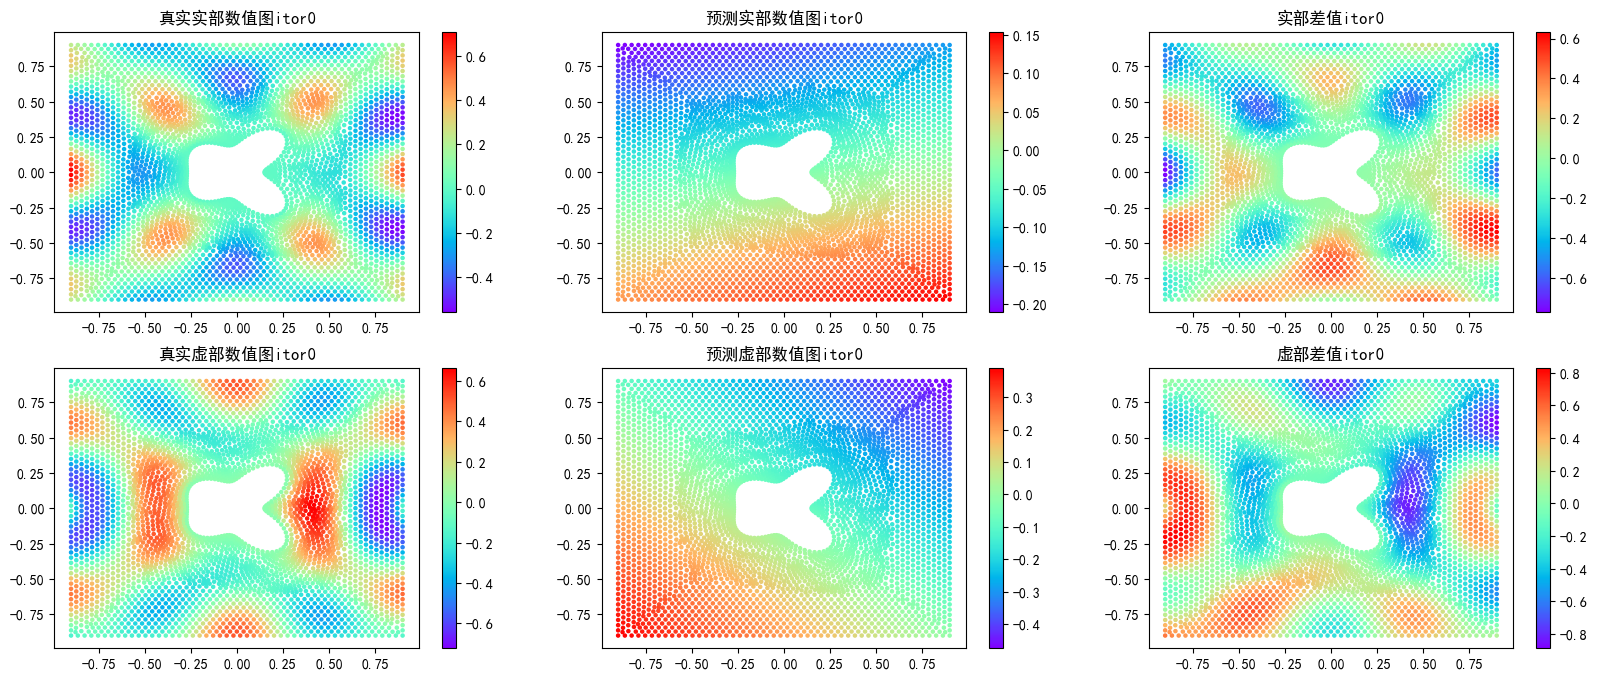

0.13541780412197113 0.12603673338890076 0.009381075389683247 1.1765698194503784
边界误差 =  tensor(0.7660, device='cuda:0', grad_fn=<DivBackward0>)


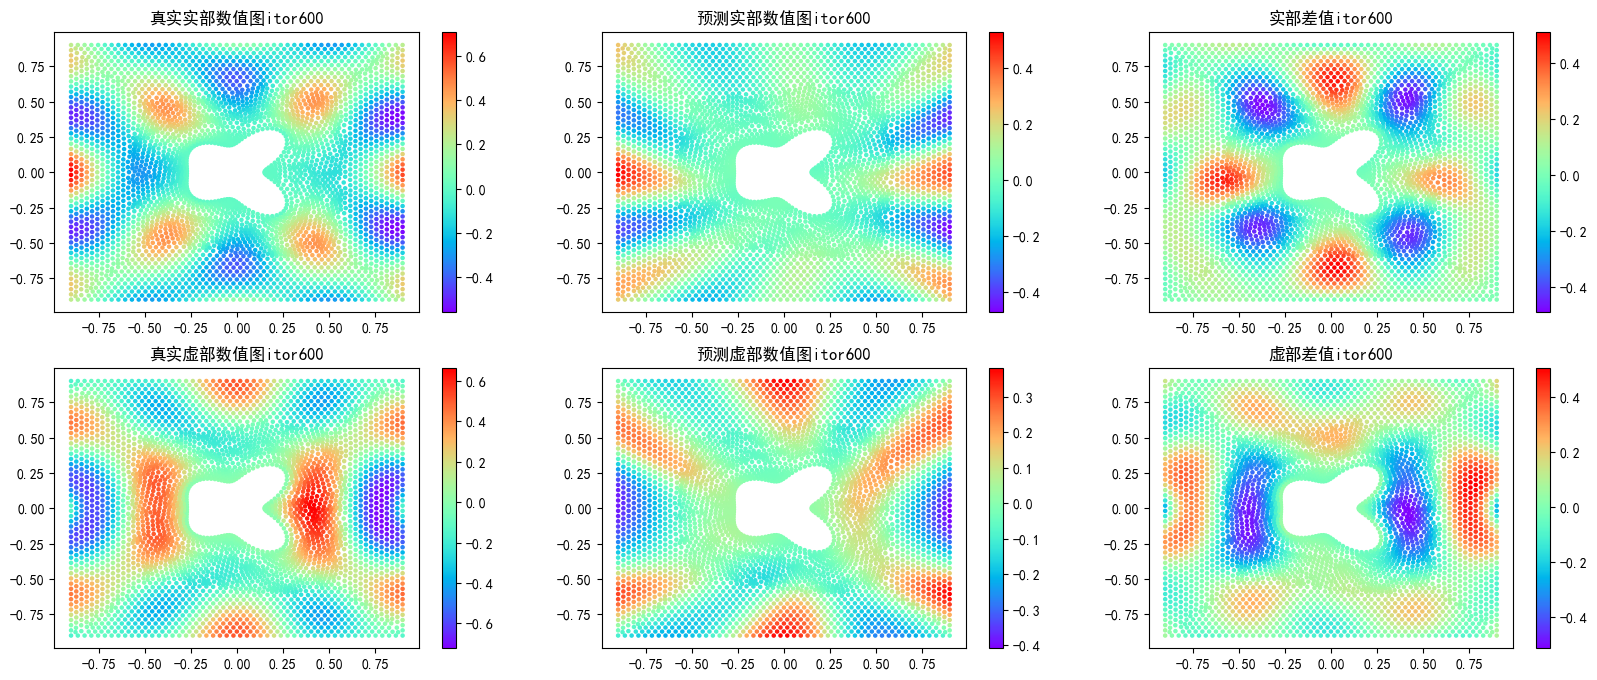

0.02282935380935669 0.013462279923260212 0.009367074817419052 0.7659832835197449


KeyboardInterrupt: 

In [40]:


layers = np.array([2, 100,100,100,100,100, 2]) #3 hidden layers

PINN = Sequentialmodel(layers)
       
PINN.to(device)

'Neural Network Summary'

print(PINN)

params = list(PINN.parameters())

'''Optimization'''

# 'L-BFGS Optimizer'

# optimizer = torch.optim.LBFGS(PINN.parameters(), lr=1, 
#                               max_iter = 20, 
#                               max_eval = None, 
#                               tolerance_grad = 1e-06, 
#                               tolerance_change = 1e-09, 
#                               history_size = 100, 
#                               line_search_fn = 'strong_wolfe')

# optimizer.zero_grad()     # zeroes the gradient buffers of all parameters

# optimizer.step(PINN.closure)


'Adam Optimizer'

optimizer = optim.Adam(PINN.parameters(), lr=0.001,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


max_iter = 30000
start_time = time.time()

for i in range(max_iter):

    #下面注释为adam优化器设置
    loss,loss_u,loss_f = PINN.loss(X_u_train, u_train, X_f_train)
           
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss.backward() #backprop
    optimizer.step()

    # optimizer.zero_grad()
    # optimizer.step( PINN.closure)
    # print(loss.item(),loss_u.item(),loss_f.item())
    if i % (max_iter/50) == 0:

       #error_vec, u_pred = PINN.test_BC(X_u_train,u_train,i)
        error_vec, u_pred = PINN.test_train(X_f_train,u_f_train,i,out_grad=False)
        print(loss.item(),loss_u.item(),loss_f.item(),error_vec.item())
        


elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))


''' Model Accuracy ''' 
error_vec, u_pred = PINN.test()

print('Test Error: %.5f'  % (error_vec))


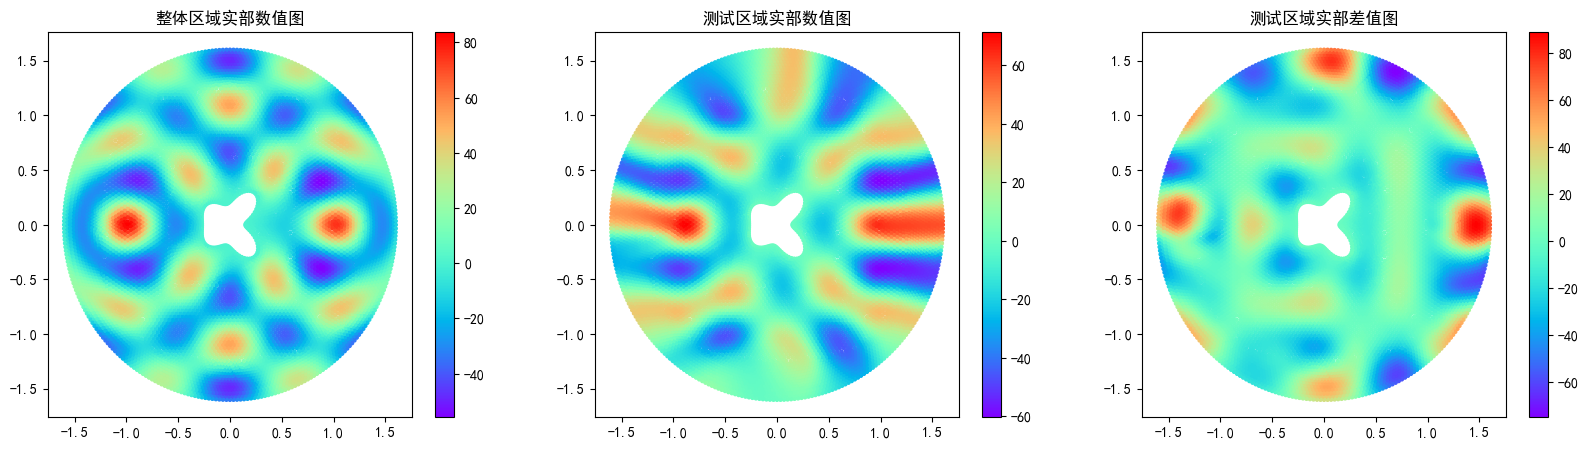

In [10]:
error_vec, u_pred = PINN.test()
plt.figure(figsize=(20, 5))
plt.subplot(131)
scatter = plt.scatter(coordinates_mesh[:,0],coordinates_mesh[:,1],s=5,c =coordinates_mesh[:,2],cmap='rainbow' )
plt.colorbar(scatter)
plt.title("整体区域实部数值图")
plt.subplot(132)
scatter = plt.scatter(coordinates_mesh[:,0],coordinates_mesh[:,1],s=5,c =u_pred.cpu().detach().numpy()[:,0]*100,cmap='rainbow')
plt.colorbar(scatter)
plt.title("测试区域实部数值图")
plt.subplot(133)
scatter = plt.scatter(coordinates_mesh[:,0],coordinates_mesh[:,1],s=5,c =u_pred.cpu().detach().numpy()[:,0]*100-coordinates_mesh[:,2],cmap='rainbow')
plt.colorbar(scatter)
plt.title("测试区域实部差值图")
plt.show()

NameError: name 'x_1' is not defined

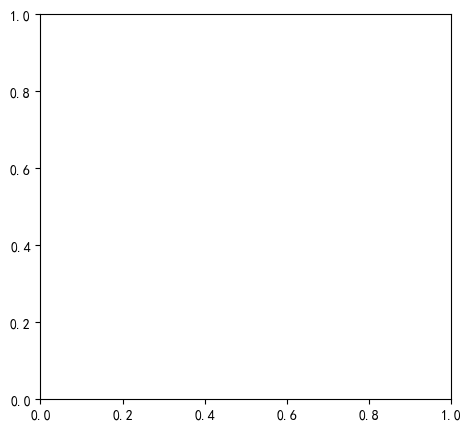

In [11]:
''' Solution Plot '''
solutionplot(u_pred,X_u_train,u_train)